In [61]:
# Data manipulation 
import pandas as pd
import numpy as np

# Visualization 
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20,10)
plt.style.use('fivethirtyeight')

# XGBoost Classifier
from xgboost import XGBClassifier, plot_importance, Booster, plot_tree, to_graphviz, DMatrix

# Preprocessing & Cross validation
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit, cross_val_score, GridSearchCV

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_roc_curve


# Import yahoo finance library
import yfinance as yf

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [62]:
spy = yf.Ticker ("SPY")
hist = spy.history(period="max")
interval = "1d"

df = yf.download("SPY", start="2000-01-01", end="2023-05-31")
df = df[['Adj Close']]

# Calculate returns
df['Returns'] = np.log(df).diff()
df['Ret_1M'] = df['Returns'].rolling(20).sum()

# Output first five values
df.head()

[*********************100%***********************]  1 of 1 completed


,Adj Close,Returns,Ret_1M
Date,,,
2000-01-03,94.595108,NaN,NaN
2000-01-04,90.895844,-0.039891,NaN
2000-01-05,91.058449,0.001787,NaN
2000-01-06,89.595055,-0.016201,NaN
2000-01-07,94.798317,0.056452,NaN


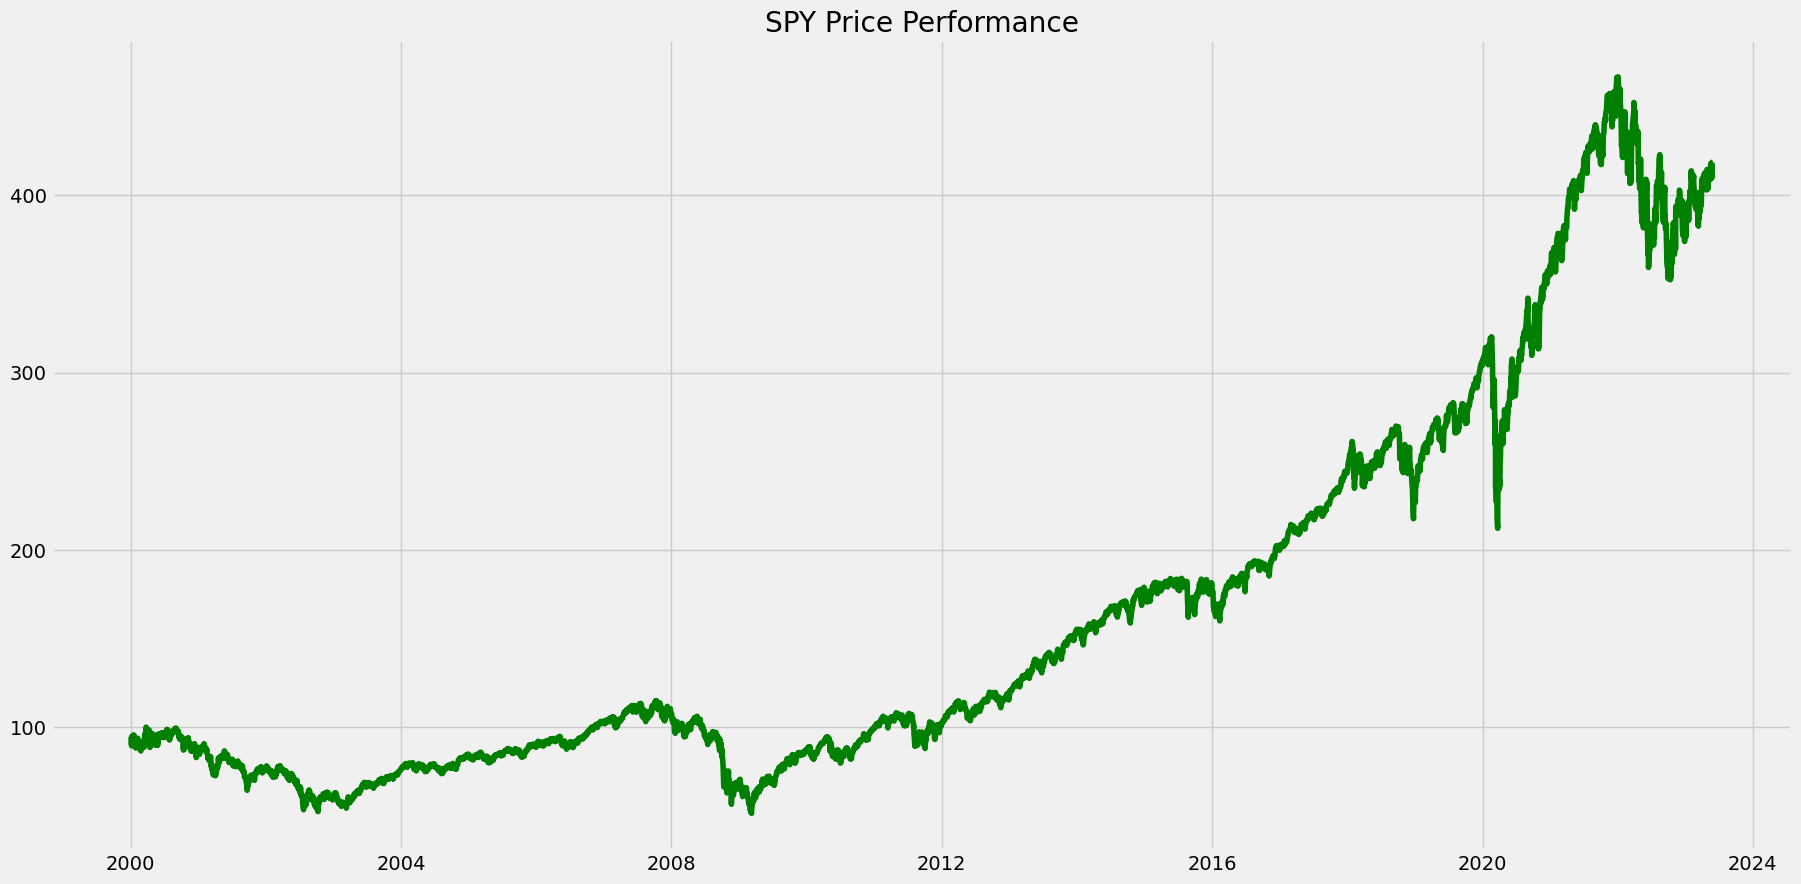

In [63]:
# Visualize raw price series
plt.title('SPY Price Performance')
plt.plot(df['Adj Close'], color='green');

In [64]:
# Create features (predictors) list
features_list = []
for r in range(10, 65, 5):
    df['Ret_'+str(r)] = df.Returns.rolling(r).sum()
    df['Std_'+str(r)] = df.Returns.rolling(r).std()
    features_list.append('Ret_'+str(r))
    features_list.append('Std_'+str(r))

# Drop NaN values
df.dropna(inplace=True)

In [65]:
# Define Target
df['Target'] = np.where(df['Ret_1M'].shift(1)>0.00154,1,0)

# Check output
df

,Adj Close,Returns,Ret_1M,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,...,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60,Target
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-29,98.605263,0.001034,0.090847,0.080963,0.016388,0.102197,0.017096,0.090847,0.016542,0.104484,...,0.015027,0.065879,0.015623,0.038944,0.015694,0.035949,0.015363,0.041519,0.017367,0
2000-03-30,96.954750,-0.016880,0.073289,0.018427,0.011734,0.056513,0.016967,0.073289,0.017210,0.107946,...,0.015315,0.056957,0.015801,0.013953,0.015853,0.031107,0.015451,0.064530,0.016697,1
2000-03-31,98.055069,0.011285,0.066025,0.023125,0.012035,0.073136,0.016873,0.066025,0.016954,0.122857,...,0.015243,0.072244,0.015850,0.040662,0.015762,0.052389,0.015448,0.074028,0.016749,1
2000-04-03,98.625610,0.005802,0.081617,0.034044,0.011779,0.089925,0.016292,0.081617,0.016677,0.107899,...,0.015233,0.109737,0.015023,0.048626,0.015772,0.044738,0.015368,0.096031,0.016601,1
2000-04-04,97.892029,-0.007466,0.093683,0.006264,0.010560,0.096766,0.015771,0.093683,0.015981,0.090838,...,0.015292,0.075494,0.014625,0.069912,0.015231,0.023786,0.015307,0.032113,0.014994,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23,412.557526,-0.011286,0.019533,0.007660,0.007029,0.007880,0.008019,0.019533,0.008864,-0.000290,...,0.007965,0.050393,0.008236,0.075715,0.008768,0.027315,0.009299,0.044119,0.009199,1
2023-05-24,409.568604,-0.007271,0.016507,-0.004272,0.007301,0.007496,0.008044,0.016507,0.008983,-0.007392,...,0.008058,0.030076,0.008123,0.052048,0.008585,0.035491,0.009102,0.040551,0.009239,1
2023-05-25,413.115448,0.008623,0.005417,0.006096,0.007812,0.023227,0.008007,0.005417,0.008049,0.006703,...,0.007859,0.055892,0.007735,0.066945,0.008584,0.042483,0.009165,0.053017,0.009276,1


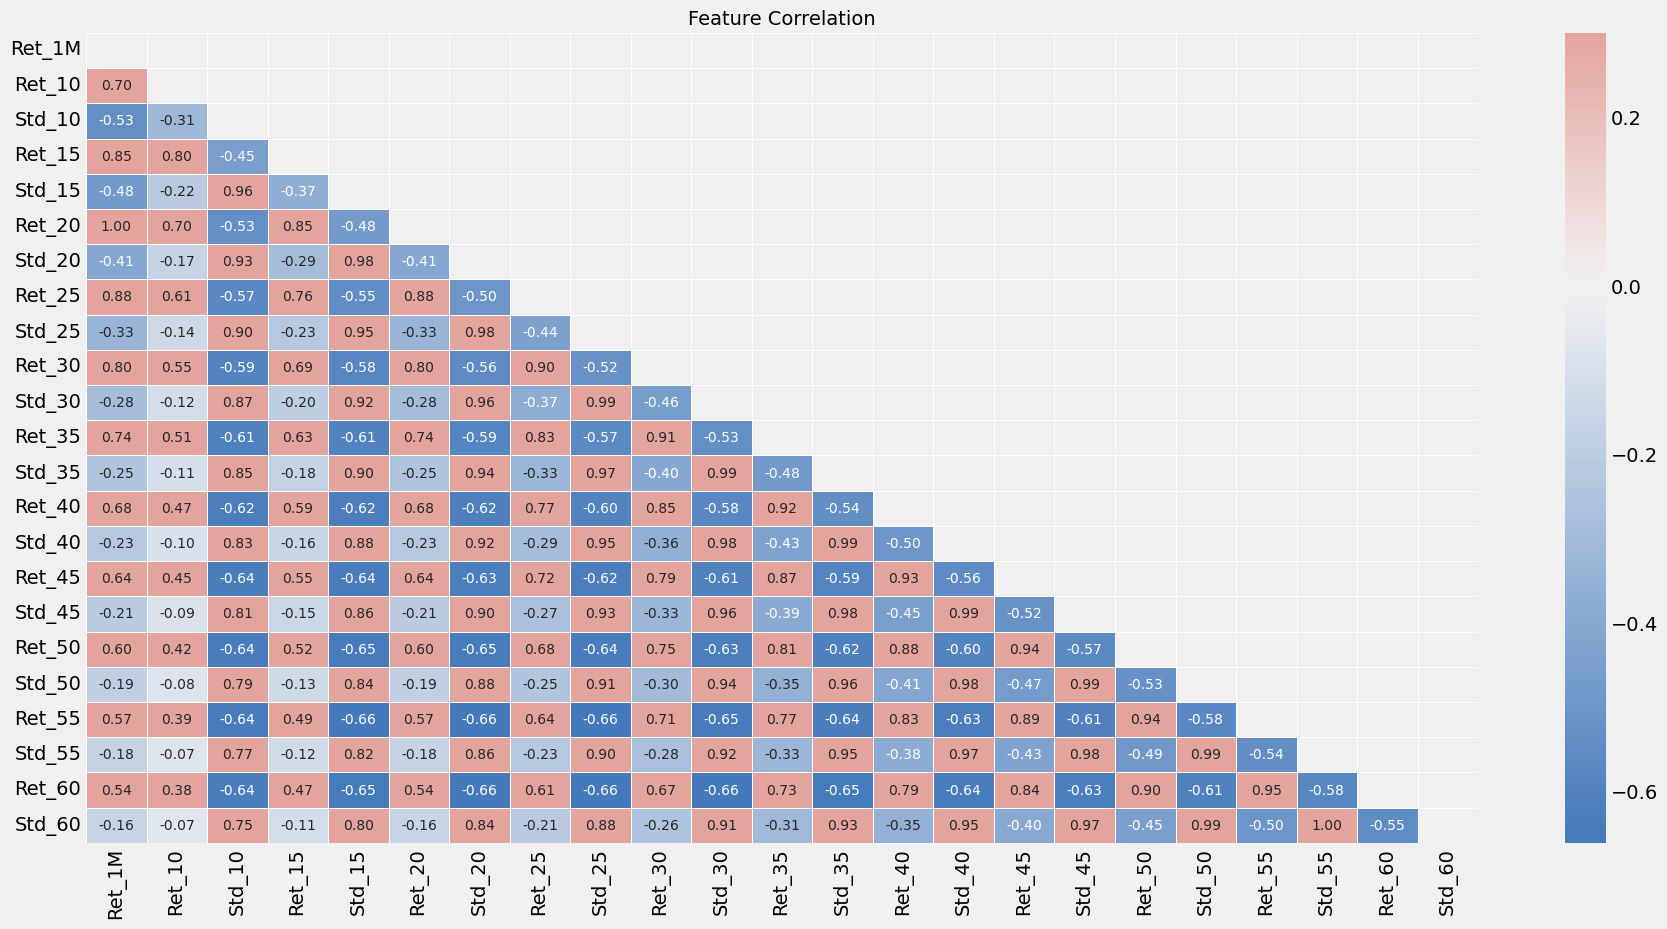

In [66]:
# Derive features correlation
import seaborn as sns
corrmat = df.drop(['Adj Close', 'Returns', 'Target'],axis=1).corr()

# Visualize feature correlation
fig, ax = plt.subplots()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(250, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corrmat, annot=True, annot_kws={"size": 10}, 
            fmt="0.2f", mask=mask, cmap=cmap, vmax=.3, center=0,
            square=False, linewidths=.5, cbar_kws={"shrink": 1})

ax.set_title('Feature Correlation', fontsize=14, color='black');

In [67]:
# Convert to NumPy
X = df.drop(['Adj Close', 'Returns', 'Ret_1M', 'Target'],axis=1)

X

,Ret_10,Std_10,Ret_15,Std_15,Ret_20,Std_20,Ret_25,Std_25,Ret_30,Std_30,...,Ret_40,Std_40,Ret_45,Std_45,Ret_50,Std_50,Ret_55,Std_55,Ret_60,Std_60
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-29,0.080963,0.016388,0.102197,0.017096,0.090847,0.016542,0.104484,0.016044,0.071952,0.015870,...,0.072949,0.015027,0.065879,0.015623,0.038944,0.015694,0.035949,0.015363,0.041519,0.017367
2000-03-30,0.018427,0.011734,0.056513,0.016967,0.073289,0.017210,0.107946,0.015837,0.069911,0.015951,...,0.055182,0.015315,0.056957,0.015801,0.013953,0.015853,0.031107,0.015451,0.064530,0.016697
2000-03-31,0.023125,0.012035,0.073136,0.016873,0.066025,0.016954,0.122857,0.015806,0.086381,0.015967,...,0.051515,0.015243,0.072244,0.015850,0.040662,0.015762,0.052389,0.015448,0.074028,0.016749
2000-04-03,0.034044,0.011779,0.089925,0.016292,0.081617,0.016677,0.107899,0.015460,0.113885,0.015281,...,0.061472,0.015233,0.109737,0.015023,0.048626,0.015772,0.044738,0.015368,0.096031,0.016601
2000-04-04,0.006264,0.010560,0.096766,0.015771,0.093683,0.015981,0.090838,0.015593,0.108963,0.015378,...,0.055541,0.015292,0.075494,0.014625,0.069912,0.015231,0.023786,0.015307,0.032113,0.014994
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-05-23,0.007660,0.007029,0.007880,0.008019,0.019533,0.008864,-0.000290,0.008659,0.010609,0.008317,...,0.043433,0.007965,0.050393,0.008236,0.075715,0.008768,0.027315,0.009299,0.044119,0.009199
2023-05-24,-0.004272,0.007301,0.007496,0.008044,0.016507,0.008983,-0.007392,0.008780,0.007422,0.008395,...,0.038409,0.008058,0.030076,0.008123,0.052048,0.008585,0.035491,0.009102,0.040551,0.009239
2023-05-25,0.006096,0.007812,0.023227,0.008007,0.005417,0.008049,0.006703,0.008886,0.002850,0.008191,...,0.032601,0.007859,0.055892,0.007735,0.066945,0.008584,0.042483,0.009165,0.053017,0.009276


In [68]:
# Define label or target 
y = df['Target']
y

Date
2000-03-29    0
2000-03-30    1
2000-03-31    1
2000-04-03    1
2000-04-04    1
             ..
2023-05-23    1
2023-05-24    1
2023-05-25    1
2023-05-26    1
2023-05-30    1
Name: Target, Length: 5829, dtype: int32

In [69]:
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 4663, 1166


In [70]:
# Scale and fit the classifier model
xgbcls =  XGBClassifier()
xgbcls.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [71]:
# Predicting the test dataset
y_pred = xgbcls.predict(X_test)

In [73]:
# Output prediction scoare
print(f'Train Accuracy: {xgbcls.score(X_train,y_train):0.4}')
print(f'Test Accuracy: {xgbcls.score(X_test,y_test):0.4}')

Train Accuracy: 1.0
Test Accuracy: 0.9237


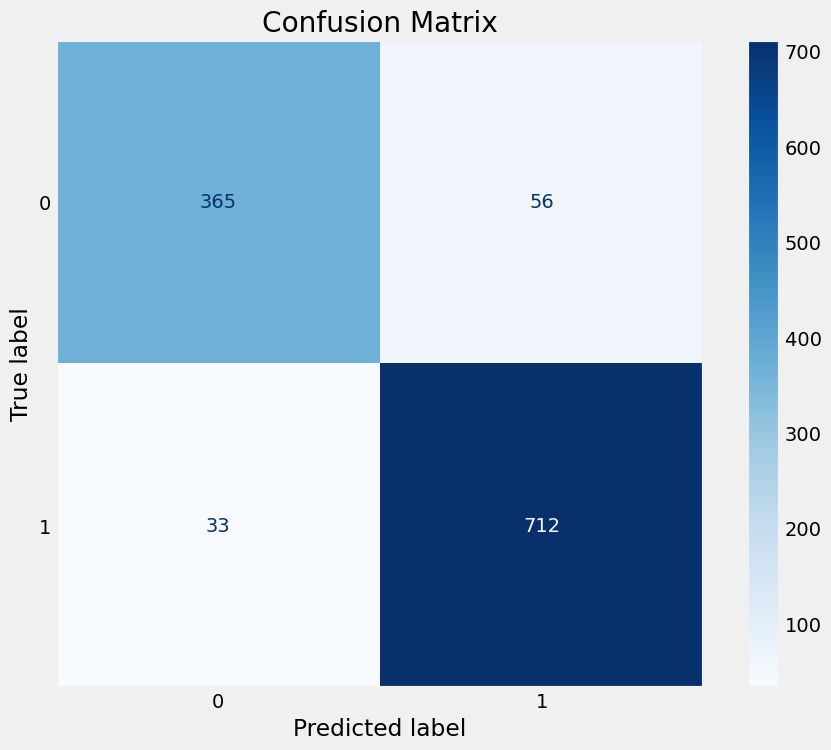

In [74]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10,8))
plot_confusion_matrix(xgbcls, X_test, y_test, ax=ax, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

In [49]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.71      0.87      0.79        63
           1       0.90      0.77      0.83        97

    accuracy                           0.81       160
   macro avg       0.81      0.82      0.81       160
weighted avg       0.83      0.81      0.81       160



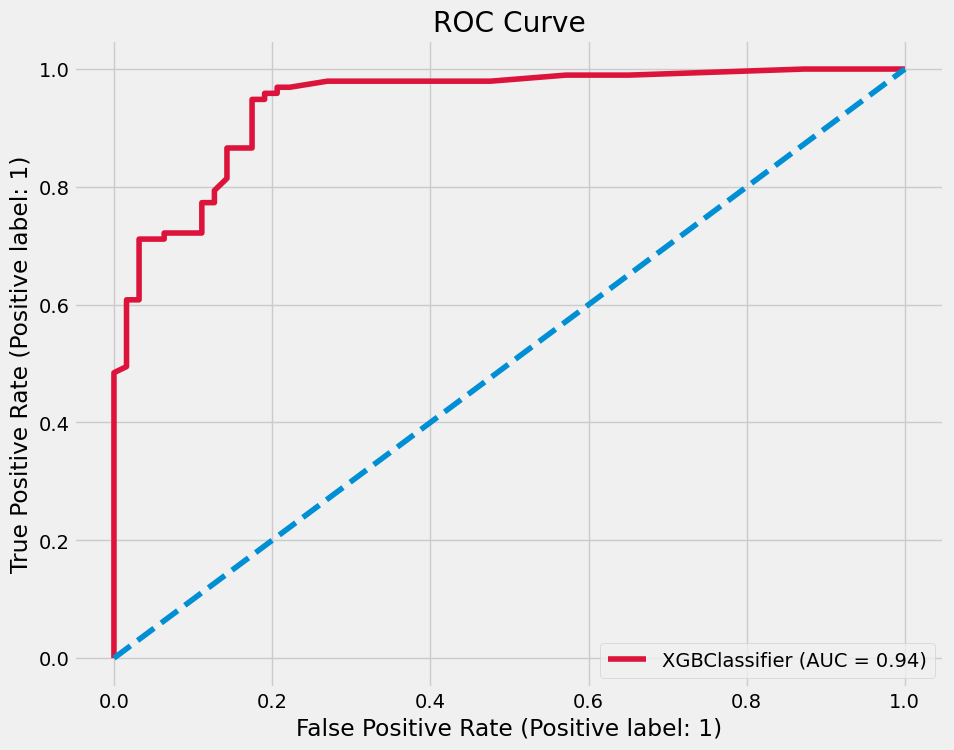

In [50]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc_curve(xgbcls, X_test, y_test, ax=ax, color='crimson')
ax.plot([0,1], [0,1], linestyle='--')
ax.set_title('ROC Curve');

In [51]:
# Timeseries CV 3-split
tscv = TimeSeriesSplit(n_splits=3)
for train, test in tscv.split(X):
    print(train, test)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200] [201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 

In [52]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5)

In [53]:
# Get params list
xgbcls.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': None,
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'gpu_id': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [54]:
# Hyper parameter optimization
param_grid = {'learning_rate': [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
              'max_depth': [3, 4, 5, 6, 8, 10, 12, 15],
              'min_child_weight': [1, 3, 5, 7],
              'gamma': [0.0, 0.1, 0.2 , 0.3, 0.4],
              'colsample_bytree': [0.3, 0.4, 0.5 , 0.7]}

In [55]:
random_search = RandomizedSearchCV(xgbcls, param_grid, n_iter=100, scoring='f1', n_jobs=-1, cv=tscv, random_state=42, verbose=1)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, gpu_id=None,
                                           grow_policy=N...
                                           monotone_constraints=None,
                                           n_estimators=100, n_jobs=None,
                                           num_parallel_tree=None,
             

In [56]:
# Refit the XGB Classifier with the best params
cls = XGBClassifier(**random_search.best_params_) 

cls.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_test, y_test)],
        eval_metric='logloss',
        verbose=True)

[0]	validation_0-logloss:0.62633	validation_1-logloss:0.64087
[1]	validation_0-logloss:0.58244	validation_1-logloss:0.62062
[2]	validation_0-logloss:0.53664	validation_1-logloss:0.58019
[3]	validation_0-logloss:0.49772	validation_1-logloss:0.54886
[4]	validation_0-logloss:0.45635	validation_1-logloss:0.50916
[5]	validation_0-logloss:0.42133	validation_1-logloss:0.47441
[6]	validation_0-logloss:0.39813	validation_1-logloss:0.45738
[7]	validation_0-logloss:0.37816	validation_1-logloss:0.44256
[8]	validation_0-logloss:0.35302	validation_1-logloss:0.41860
[9]	validation_0-logloss:0.33845	validation_1-logloss:0.40824
[10]	validation_0-logloss:0.32267	validation_1-logloss:0.39659
[11]	validation_0-logloss:0.30397	validation_1-logloss:0.37768
[12]	validation_0-logloss:0.28966	validation_1-logloss:0.36916
[13]	validation_0-logloss:0.27451	validation_1-logloss:0.35469
[14]	validation_0-logloss:0.26402	validation_1-logloss:0.35028
[15]	validation_0-logloss:0.25202	validation_1-logloss:0.33833
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.4, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=7, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

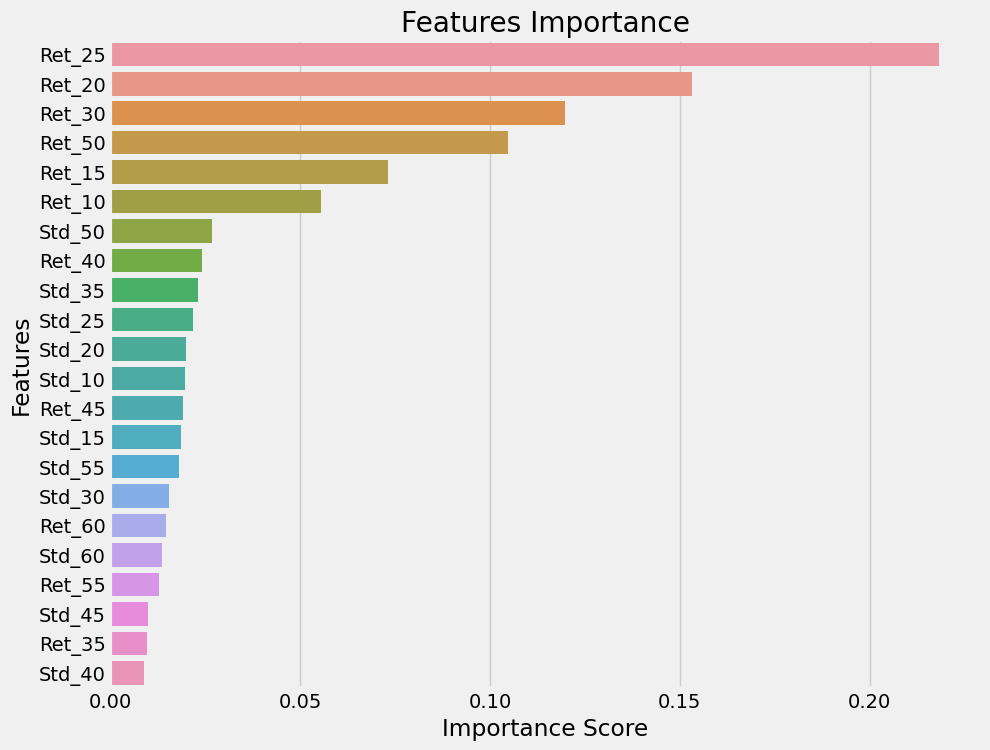

In [57]:
# Plot feature importance
# feature importance_type = 'gain'

fig, ax = plt.subplots(figsize=(10,8))
feature_imp = pd.DataFrame({'Importance Score': cls.feature_importances_,'Features': X.columns}).sort_values(by='Importance Score', ascending=False)

sns.barplot(x=feature_imp['Importance Score'], y=feature_imp['Features'])
ax.set_title('Features Importance');

In [75]:
# Predicting the test dataset
y_pred = cls.predict(X_test)
y_pred

array([0, 0, 0, ..., 1, 1, 1])

In [76]:
# Measure Accuracy
acc_train = accuracy_score(y_train, cls.predict(X_train))
acc_test = accuracy_score(y_test, y_pred)
acc_train, acc_test

(0.8884838087068411, 0.9476843910806175)

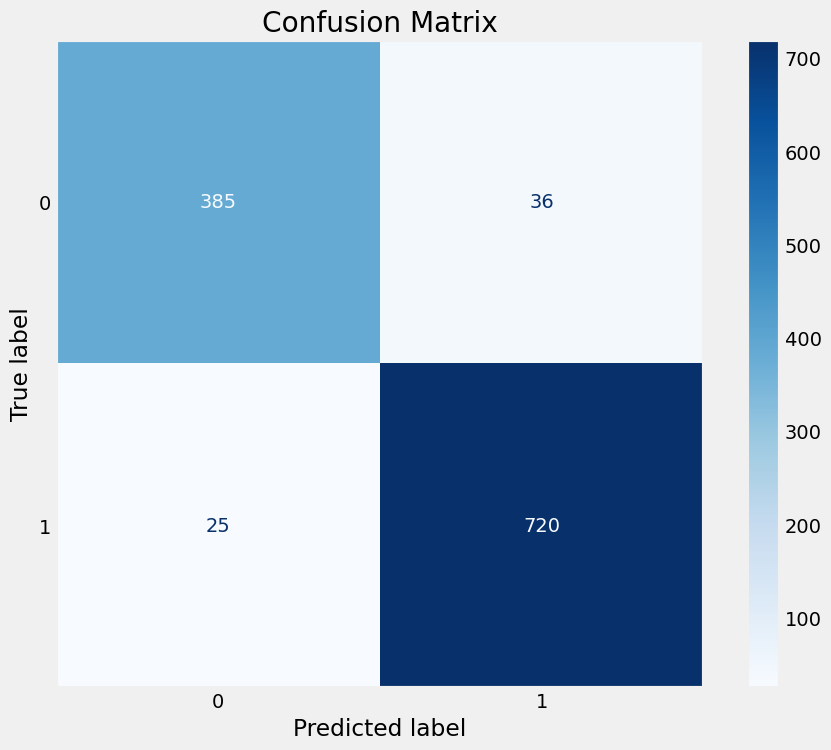

In [77]:
# Plot confusion matrix
fig, ax = plt.subplots(figsize=(10,8))
plot_confusion_matrix(cls, X_test, y_test, ax=ax, cmap='Blues', values_format='.4g')
plt.title('Confusion Matrix')
plt.grid(False)

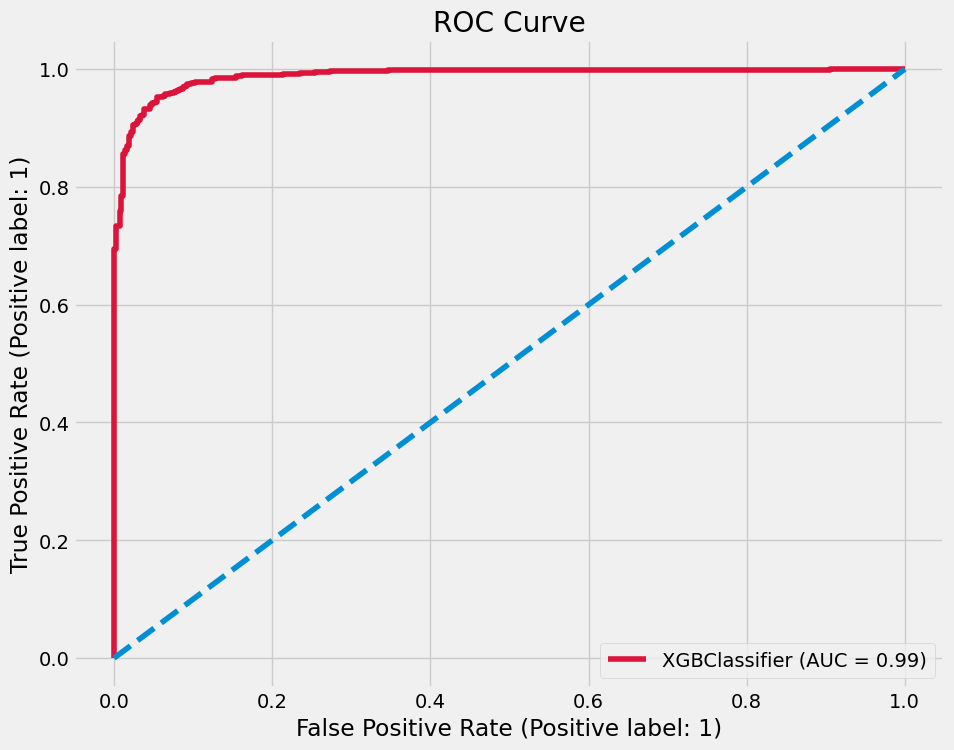

In [78]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc_curve(cls, X_test, y_test, ax=ax, color='crimson')
ax.plot([0,1], [0,1], linestyle='--')
ax.set_title('ROC Curve');

In [79]:
# Cross validation score
score=cross_val_score(cls,X_train,y_train,cv=tscv)

In [80]:
# Create a new dataframe to subsume outsample data
df1 = df[-len(y_test):]

# Predict the signal and store in predicted signal column
df1['Signal'] = y_pred
    
# Calculate the strategy returns
df1['Strategy'] = df1['Returns'] * df1['Signal'].shift(1).fillna(0)

# Localize index for pyfolio
df1.index = df1.index.tz_localize('utc')

# Check the output
df1[['Adj Close', 'Returns', 'Signal', 'Strategy']].tail(10)

,Adj Close,Returns,Signal,Strategy
Date,,,,
2023-05-16 00:00:00+00:00,408.731720,-0.006705,1,-0.006705
2023-05-17 00:00:00+00:00,413.693298,0.012066,1,0.012066
2023-05-18 00:00:00+00:00,417.678497,0.009587,1,0.009587
2023-05-19 00:00:00+00:00,417.070740,-0.001456,1,-0.001456
2023-05-22 00:00:00+00:00,417.240143,0.000406,1,0.000406
2023-05-23 00:00:00+00:00,412.557526,-0.011286,1,-0.011286
2023-05-24 00:00:00+00:00,409.568604,-0.007271,1,-0.007271
2023-05-25 00:00:00+00:00,413.115448,0.008623,1,0.008623
2023-05-26 00:00:00+00:00,418.465546,0.012867,1,0.012867


In [82]:
!pip install pyfolio
# Import pyfolio
import pyfolio as pf

     ---------------------------------------- 91.1/91.1 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 52.8/52.8 kB ? eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for pyfolio: filename=pyfolio-0.9.2-py3-none-any.whl size=88677 sha256=700fc2bbaf15d9211603abbf4e2b9481f4ca7d90e935f0fe26e47bbbbf1bd533
  Stored in directory: c:\users\manju\appdata\local\pip\cache\wheels\75\c7\b9\986a1ba8adb2afce230e1a497dc11aeb33efef4fc8dfd6c649
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.whl size=39775 sha256=20517dec0bbed94f11643e30651a24fd4721b617f4141582b928914444fc0b95
  Stored in directory: c:\users\manju\appdata\local\pip\cache\wheels\67\23\d1\a4ef8ff88dc9af7b0eeb1b6fd0d90c6057eaad5a2df25f4e3f
Successfully built pyfolio empyrical


Start date,2018-10-10
End date,2023-05-30
Total months,55
,Backtest
Annual return,8.2%
Cumulative returns,43.9%
Annual volatility,12.5%
Sharpe ratio,0.69
Calmar ratio,0.57
Stability,0.80
Max drawdown,-14.4%


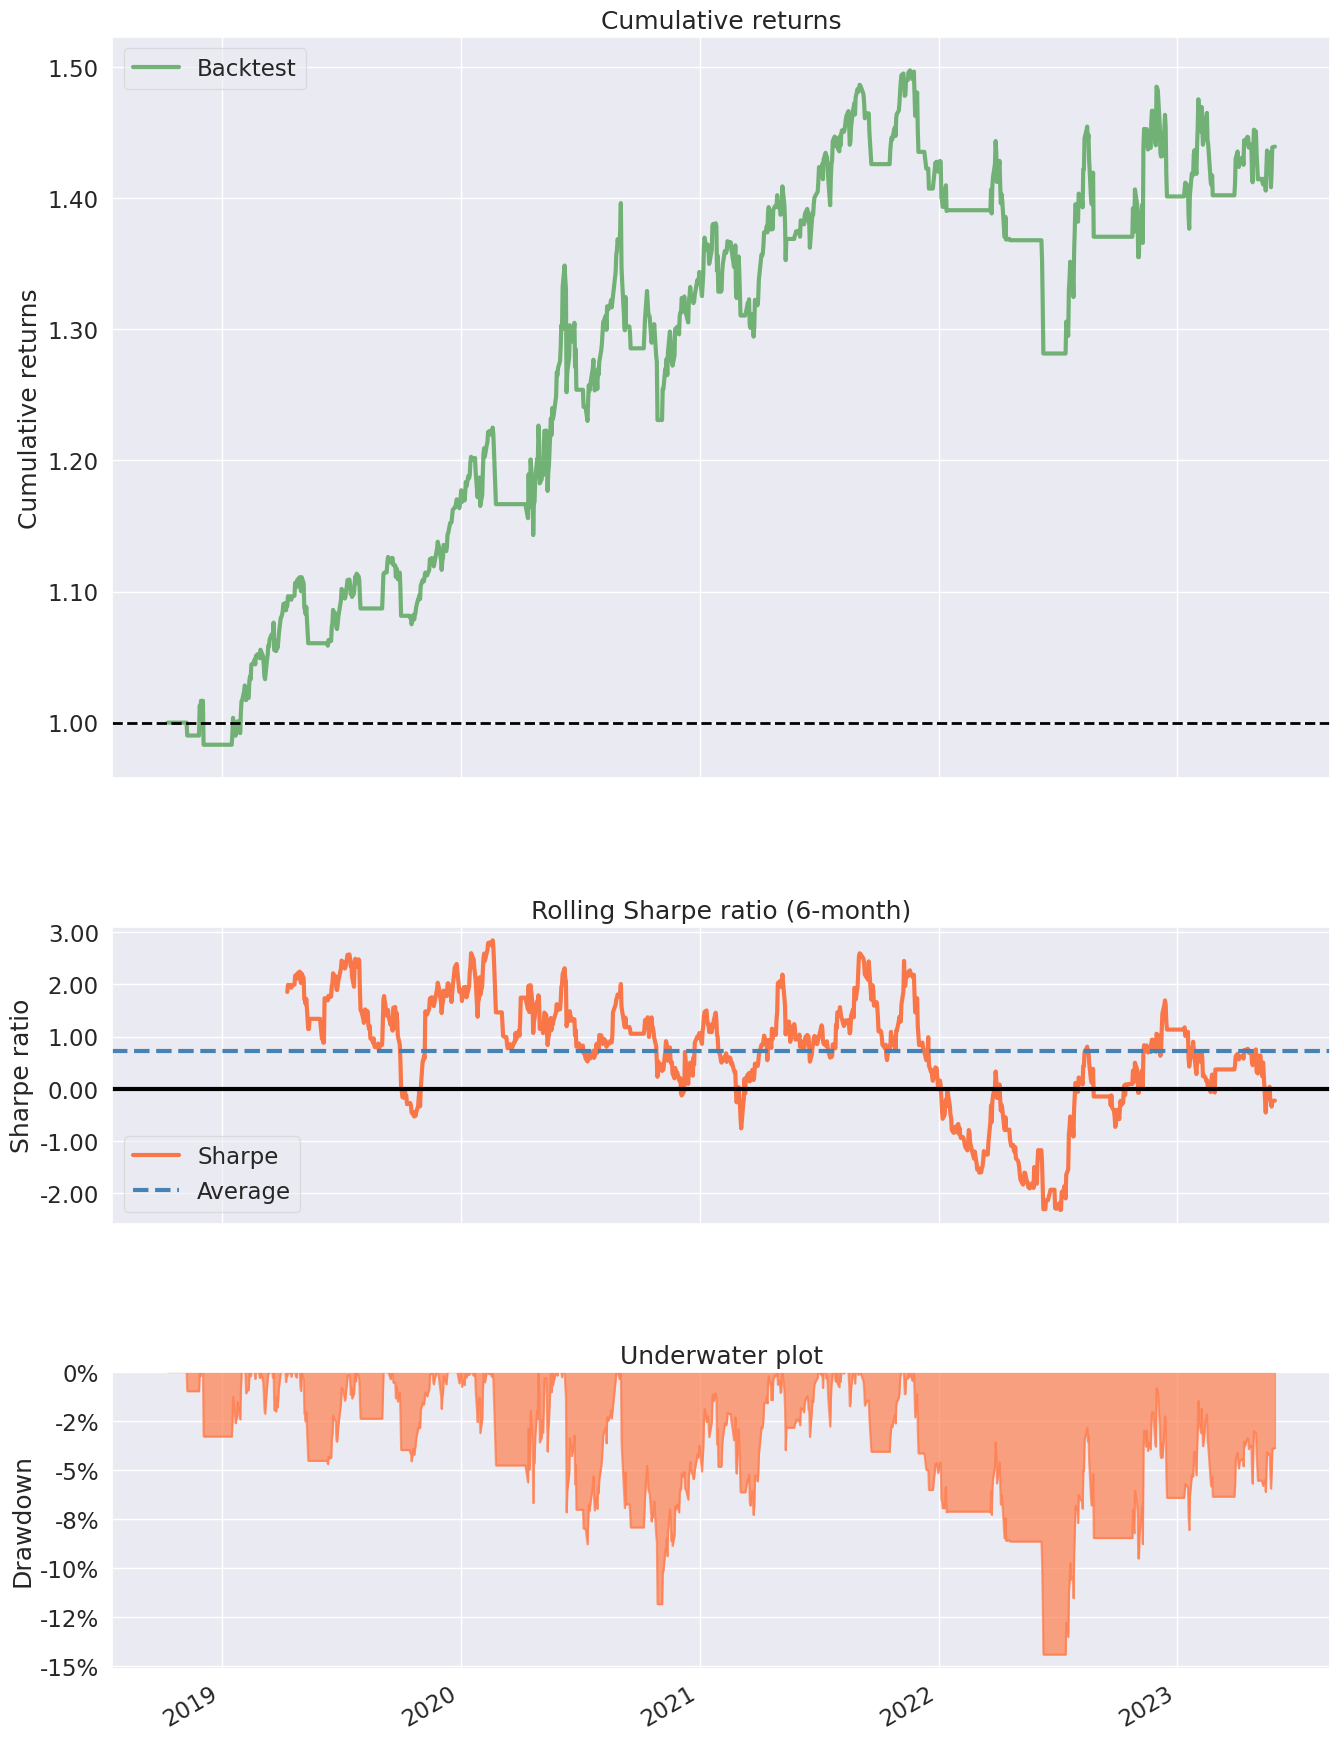

In [83]:
# Create Tear sheet using pyfolio for outsample - for X_test
pf.create_simple_tear_sheet(df1['Strategy'])